# DS 3000 - Final Project

**Student Name**: Samy Fallah, Dhilan Panjabi, Ariel Park

**Date**: 12/06/2023


### Submission Instructions
Submit this `ipynb` file to canvas.

The `ipynb` format stores outputs from the last time you ran the notebook.  (When you open a notebook it has the figures and outputs of the last time you ran it too).  To ensure that your submitted `ipynb` file represents your latest code, make sure to give a fresh run `Kernel > Restart & Run All` just before uploading the `ipynb` file to Canvas.

### Academic Integrity

**Writing your homework is an individual effort.**  You may discuss general python problems with other students but under no circumstances should you observe another student's code which was written for this assignment, from this year or past years.  Pop into office hours or DM us in MS Teams if you have a specific question about your work or if you would like another pair of eyes or talk through your code.

Don't forget to cite websites which helped you solve a problem in a unique way.  You can do this in markdown near the code or with a simple one-line comment. You do not need to cite the official python documentation.

**Documentation / style counts for credit**  Please refer to the Pep-8 style, to improve the readability and consistency of your Python code. For more information, read the following article [How to Write Beautiful Python Code With PEP 8](https://realpython.com/python-pep8/) or ask your TA's for tips.

**NOTE:<span style='color:red'> Write python expressions to answer ALL questions below and ensure that you use the `print()` function to display the output.</span>** Each question should be answered in a new code cell. For example, your solution for question 1.1 should be in a different code cell from your solution for question 1.2.

## Data Preparation
This section includes data loading, cleaning, exploratory data analysis (EDA), and feature engineering.

In [134]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor


# Load data
df_listings_2019 = pd.read_csv('2019AirBnB.csv')
df_listings_2022 = pd.read_csv('2022Listings.csv')
df_reviews = pd.read_csv('REVIEWS.csv')

[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>


In [135]:
# Conduct a sentiment analysis on Airbnb reviews to use as another explanatory variable
# Change 'date' column to datetime
df_reviews['date'] = pd.to_datetime(df_reviews['date'])

# Drop empty reviews
df_reviews = df_reviews.dropna(subset=['comments'])

# Get reviews from only 2022
mask_2022 = df_reviews['date'].dt.year == 2022
df_reviews_2022 = df_reviews[mask_2022] # Apply mask

# Get reviews from only 2019
mask_2019 = df_reviews['date'].dt.year == 2019
df_reviews_2019 = df_reviews[mask_2019] # Apply mask

# View results
print(df_reviews_2022.head())
print(df_reviews_2019.head())


# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment_scores(text):
    scores = sia.polarity_scores(text)
    return scores['compound']

# Apply sentiment analysis to the 'comments' column and create a new 'sentiment_score' column
# Values closer to 1 are "positive", values closer to -1 are "negative", values closer to 0 ar "neutral"
df_reviews_2022['sentiment_score'] = df_reviews_2022['comments'].apply(get_sentiment_scores)
df_reviews_2019['sentiment_score'] = df_reviews_2019['comments'].apply(get_sentiment_scores)

# Group by 'listing_id' and calculate the average sentiment score
df_avg_sentiment_2019 = df_reviews_2019.groupby('listing_id')['sentiment_score'].mean().reset_index()
df_avg_sentiment_2022 = df_reviews_2022.groupby('listing_id')['sentiment_score'].mean().reset_index()

# View results
print(df_avg_sentiment_2019)
print(df_avg_sentiment_2022)

      listing_id                  id       date  reviewer_id reviewer_name  \
1133       44973  596363234757173911 2022-04-02    306329514        Jayesh   
1186       75635  578190554231713950 2022-03-08     21566984       Adriane   
1187       75635  581831677979281408 2022-03-13     54904469      Nathalie   
1188       75635  592708306737347505 2022-03-28    186274413        Emilie   
1189       75635  602841419286947793 2022-04-11     70615776           Ben   

                                               comments  
1133  Great stay! Easy access to Manhattan and safe ...  
1186  Great spot. Comfortable bed, good value, clean...  
1187  We loved our stay at Patty’s place. She was so...  
1188  lovely flat with everything we needed. Close t...  
1189                Quirky flat with a super comfy bed!  
    listing_id         id       date  reviewer_id reviewer_name  \
42        2595  366477703 2019-01-02    165354250         Jacob   
43        2595  449815873 2019-05-07    168460710

/var/folders/8y/bb2m_8n915jb0h8mj_mz13080000gn/T/ipykernel_9471/567869227.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews_2022['sentiment_score'] = df_reviews_2022['comments'].apply(get_sentiment_scores)


       listing_id  sentiment_score
0            2595         0.484000
1            5121         0.966800
2            5178         0.442617
3            5295         0.660564
4            5803         0.713800
...           ...              ...
11705    41069298        -0.526700
11706    41740615        -0.027600
11707    41792753         0.752697
11708    42279171         0.683700
11709    42384501         0.651235

[11710 rows x 2 columns]
               listing_id  sentiment_score
0                    5178         0.666745
1                    5803         0.927400
2                    6848         0.941550
3                    6990         0.901533
4                    7097         0.914673
...                   ...              ...
15359  635494783850320801         0.980900
15360  635531827756587824         0.822100
15361  637585491442944314         0.983400
15362  638474663573735856         0.969000
15363  639177088317762843         0.890900

[15364 rows x 2 columns]


/var/folders/8y/bb2m_8n915jb0h8mj_mz13080000gn/T/ipykernel_9471/567869227.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews_2019['sentiment_score'] = df_reviews_2019['comments'].apply(get_sentiment_scores)


In [136]:
# Merge the reviews DFs with the listings DFs
df_airbnb_2022 = pd.merge(df_listings_2022, df_avg_sentiment_2022, left_on='id', right_on='listing_id', how='left')
df_airbnb_2019 = pd.merge(df_listings_2019, df_avg_sentiment_2019, left_on='id', right_on='listing_id', how='left')

# Replace any missing sentiment_score values with 0 (neutral)
df_airbnb_2019['sentiment_score'] = df_airbnb_2019['sentiment_score'].fillna(0)
df_airbnb_2022['sentiment_score'] = df_airbnb_2022['sentiment_score'].fillna(0)

# Drop extra 'listing_id' column
df_airbnb_2019 = df_airbnb_2019.drop('listing_id', axis=1)
df_airbnb_2022 = df_airbnb_2022.drop('listing_id', axis=1)

# View results 
print(df_airbnb_2022)
print(df_airbnb_2019)

             id                                               name    host_id  \
0          2595                              Skylit Midtown Castle       2845   
1          5121                                    BlissArtsSpace!       7356   
2          5136           Spacious Brooklyn Duplex, Patio + Garden       7378   
3          5178                   Large Furnished Room Near B'way　       8967   
4          5203                 Cozy Clean Guest Room - Family Apt       7490   
...         ...                                                ...        ...   
37405  53261541                           Central Park and You -40    2653479   
37406  51307301         1BR (bedroom 2) - SUNNY CENTRAL PARK NORTH  402215343   
37407    363320                                HOME AWAY FROM HOME     390251   
37408  44189193   Beautiful studio Apartment on Central Park West.  333993552   
37409   9170129  Modern Manhattan Central Park Apt w/ Priv Backyrd   46973966   

         host_name neighbou

2019 Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review     

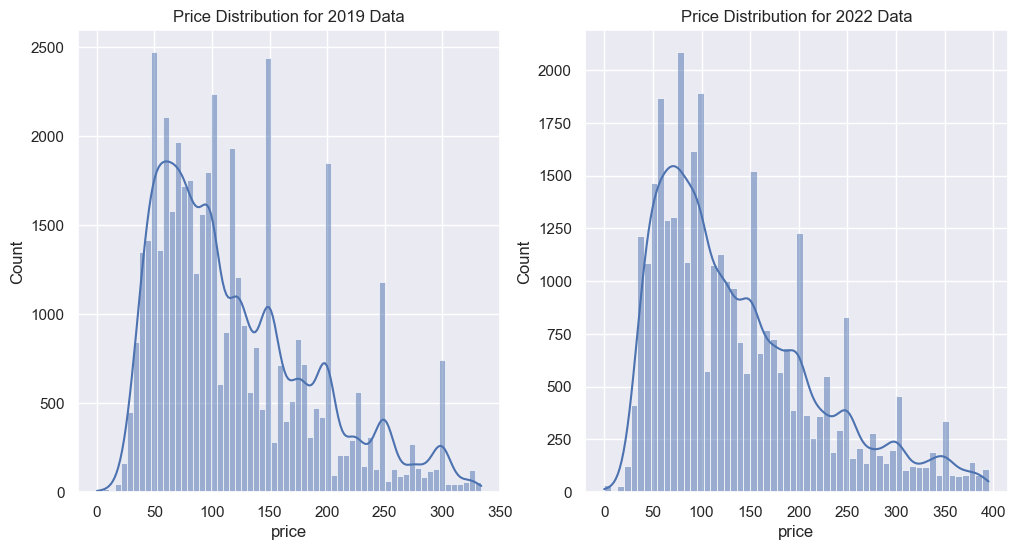

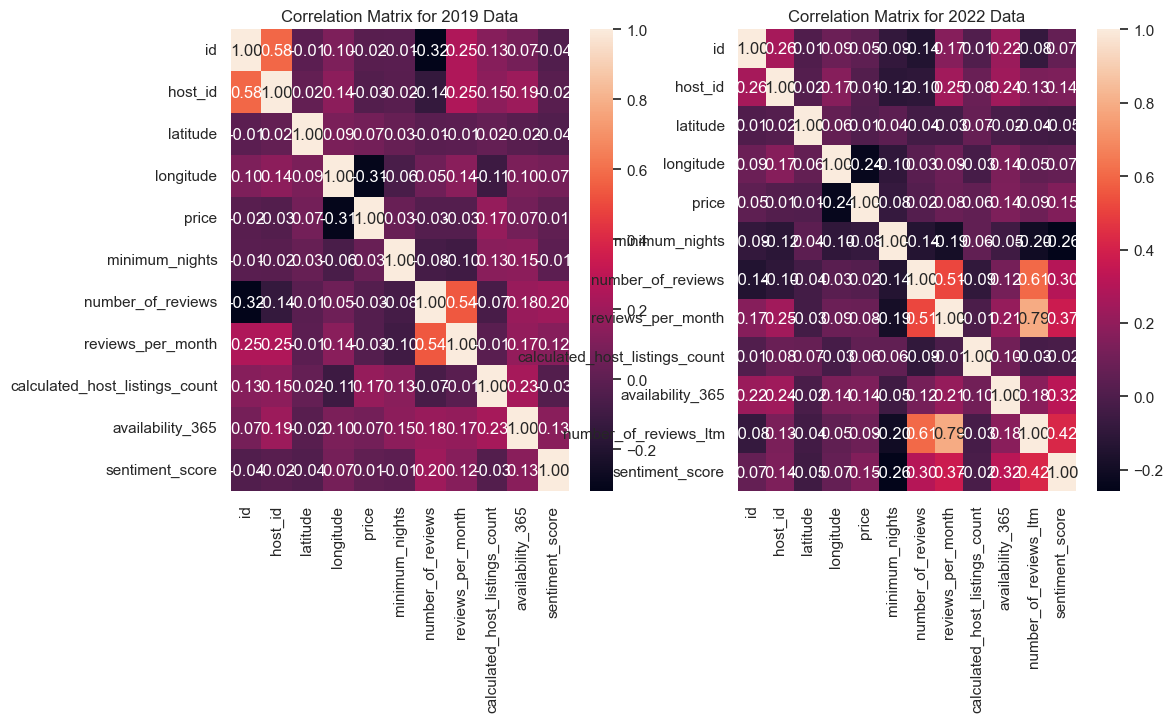

In [137]:
# Display basic info for initial assessment
print("2019 Data Info:")
print(df_airbnb_2019.info())
print(df_airbnb_2019.head())
print("\n2022 Data Info:")
print(df_airbnb_2022.info())
print(df_airbnb_2022.head())

def clean_data(df):
    # Handling missing values for numeric columns
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

    # Handling missing values for non-numeric columns
    non_numeric_cols = df.select_dtypes(exclude=['float64', 'int64']).columns
    df[non_numeric_cols] = df[non_numeric_cols].fillna('Unknown')

    # Removing duplicates
    df.drop_duplicates(inplace=True)

    return df

df_airbnb_2019 = clean_data(df_airbnb_2019)
df_airbnb_2022 = clean_data(df_airbnb_2022)

# Function to handle outliers in 'price' column
def remove_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_airbnb_2019 = remove_outliers(df_airbnb_2019, 'price')
df_airbnb_2022 = remove_outliers(df_airbnb_2022, 'price')

# Descriptive statistics
print("Descriptive Statistics for 2019 Data:")
print(df_airbnb_2019.describe())
print("\nDescriptive Statistics for 2022 Data:")
print(df_airbnb_2022.describe())

# Distribution of 'price' for both datasets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_airbnb_2019['price'], kde=True)
plt.title('Price Distribution for 2019 Data')
plt.subplot(1, 2, 2)
sns.histplot(df_airbnb_2022['price'], kde=True)
plt.title('Price Distribution for 2022 Data')
plt.show()

# Selecting only numeric columns for the correlation matrix
numeric_cols_2019 = df_airbnb_2019.select_dtypes(include=['float64', 'int64'])
numeric_cols_2022 = df_airbnb_2022.select_dtypes(include=['float64', 'int64'])

# Correlation matrix for 2019 data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(numeric_cols_2019.corr(), annot=True, fmt=".2f")
plt.title('Correlation Matrix for 2019 Data')

# Correlation matrix for 2022 data
plt.subplot(1, 2, 2)
sns.heatmap(numeric_cols_2022.corr(), annot=True, fmt=".2f")
plt.title('Correlation Matrix for 2022 Data')
plt.show()

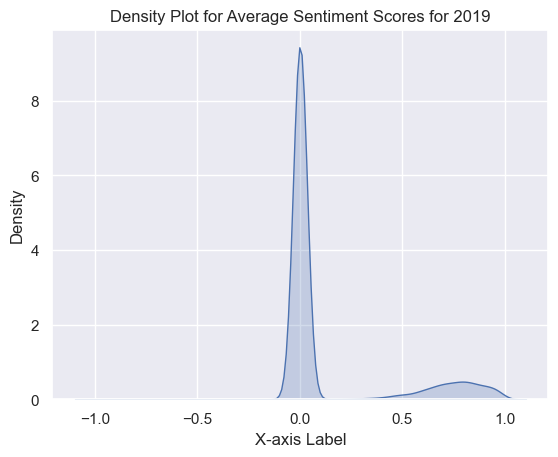

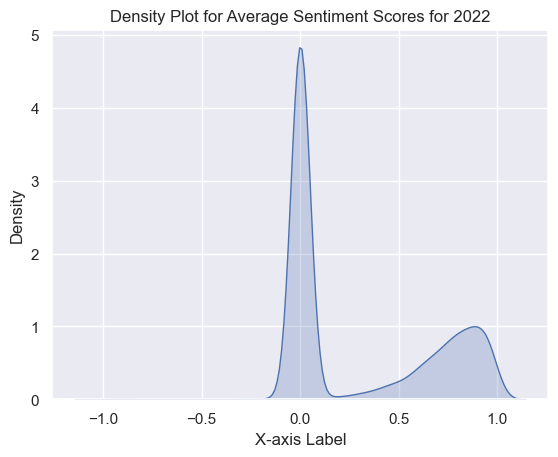

In [138]:
# Sentiment Score Distributions
sns.kdeplot(data=df_airbnb_2019['sentiment_score'], fill=True)
plt.title('Density Plot for Average Sentiment Scores for 2019')
plt.xlabel('X-axis Label')
plt.ylabel('Density')
plt.show()

sns.kdeplot(data=df_airbnb_2022['sentiment_score'], fill=True)
plt.title('Density Plot for Average Sentiment Scores for 2022')
plt.xlabel('X-axis Label')
plt.ylabel('Density')
plt.show()

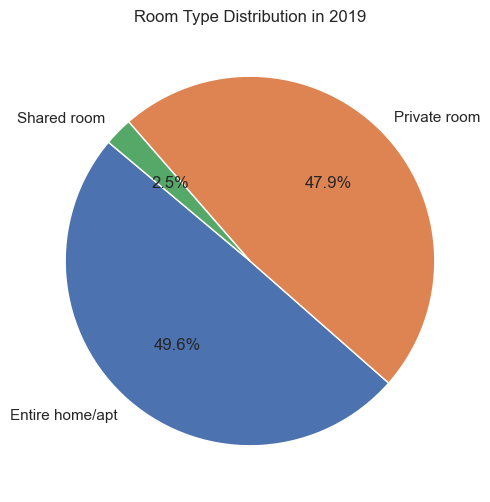

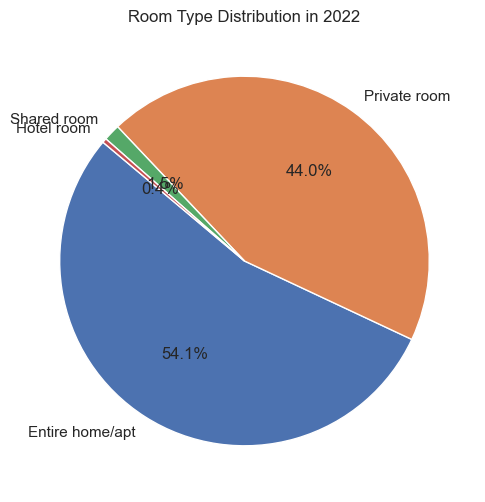

In [139]:
# Room Type Distributions
# Count the occurrences of each room type for 2019 and 2022
room_type_counts_2019 = df_airbnb_2019['room_type'].value_counts()
room_type_counts_2022 = df_airbnb_2022['room_type'].value_counts()

# Plot pie chart for 2019
plt.figure(figsize=(12, 6))
plt.pie(room_type_counts_2019, labels=room_type_counts_2019.index, autopct='%1.1f%%', startangle=140)
plt.title('Room Type Distribution in 2019')
plt.show()

# Plot pie chart for 2022
plt.figure(figsize=(12, 6))
plt.pie(room_type_counts_2022, labels=room_type_counts_2022.index, autopct='%1.1f%%', startangle=140)
plt.title('Room Type Distribution in 2022')
plt.show()


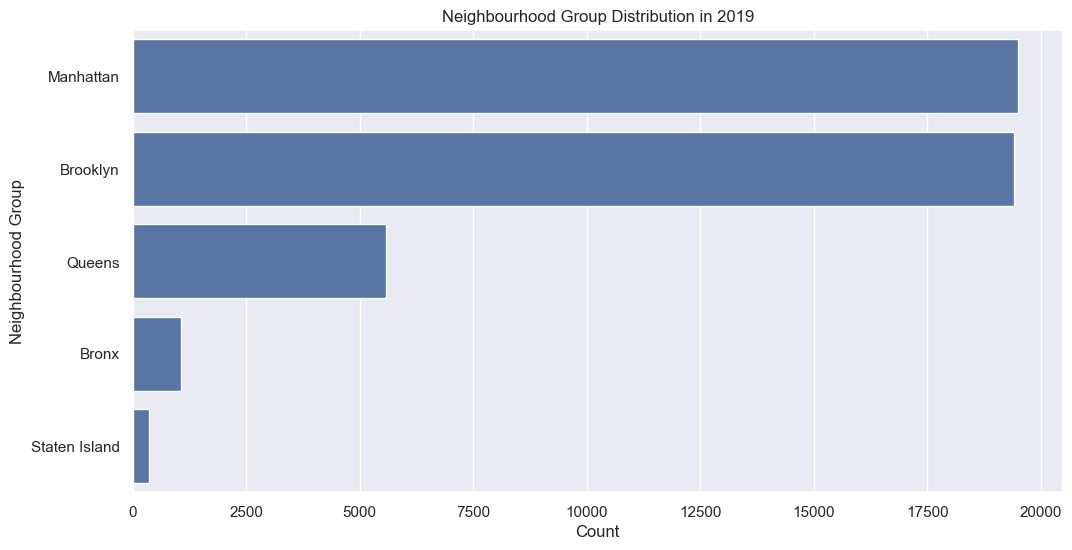

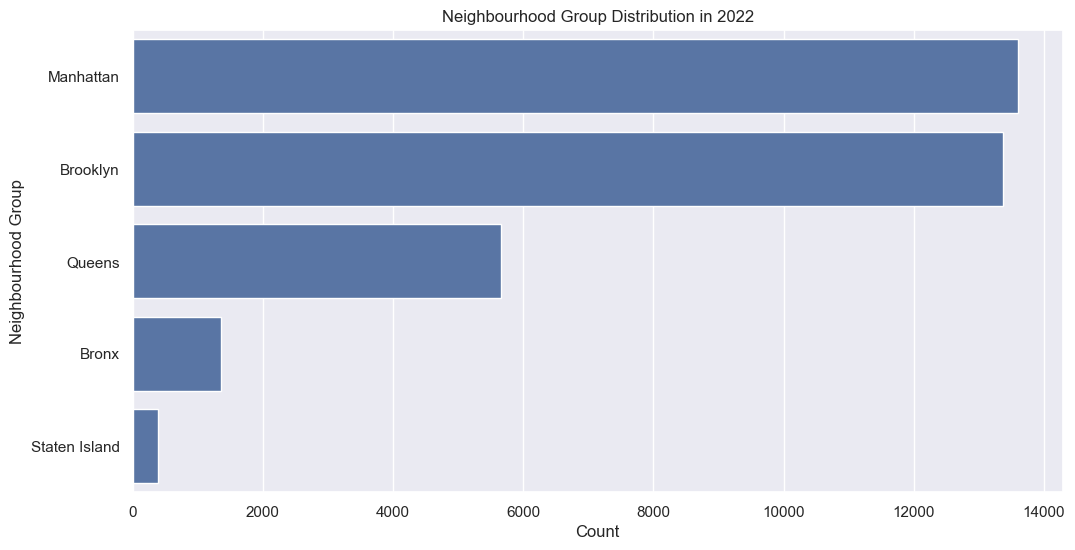

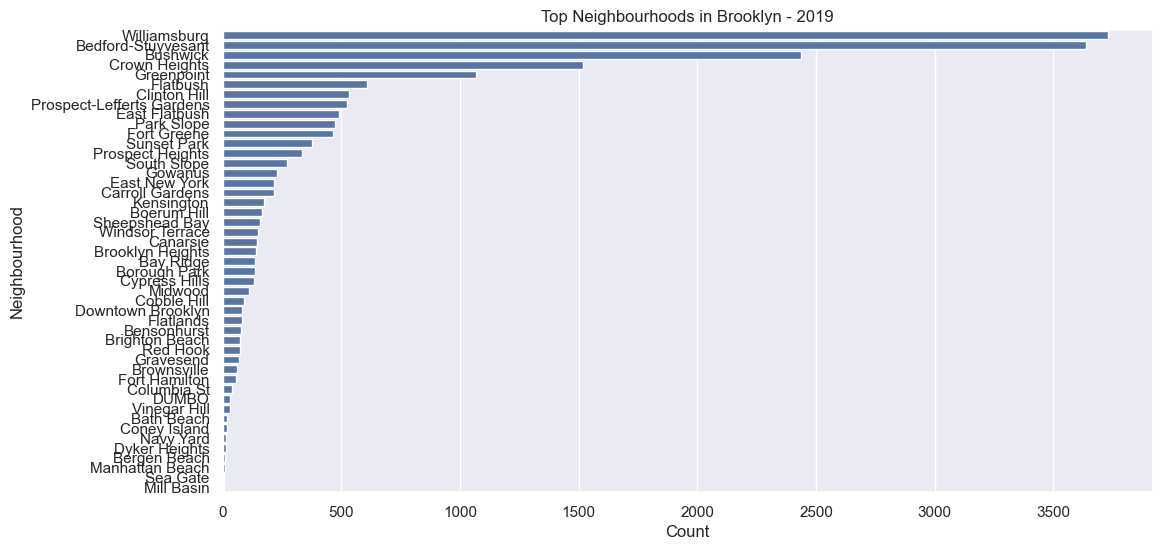

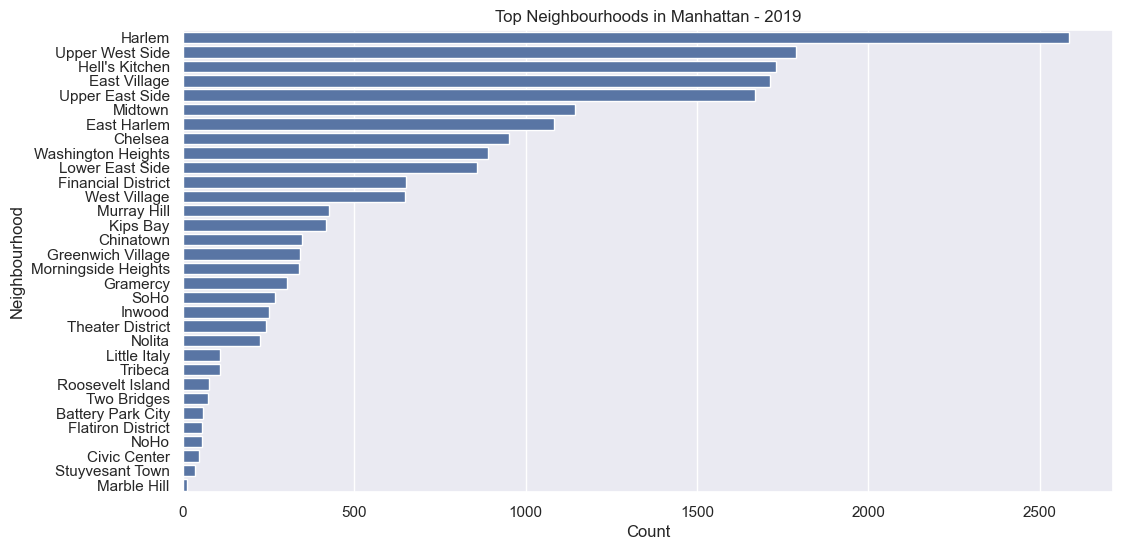

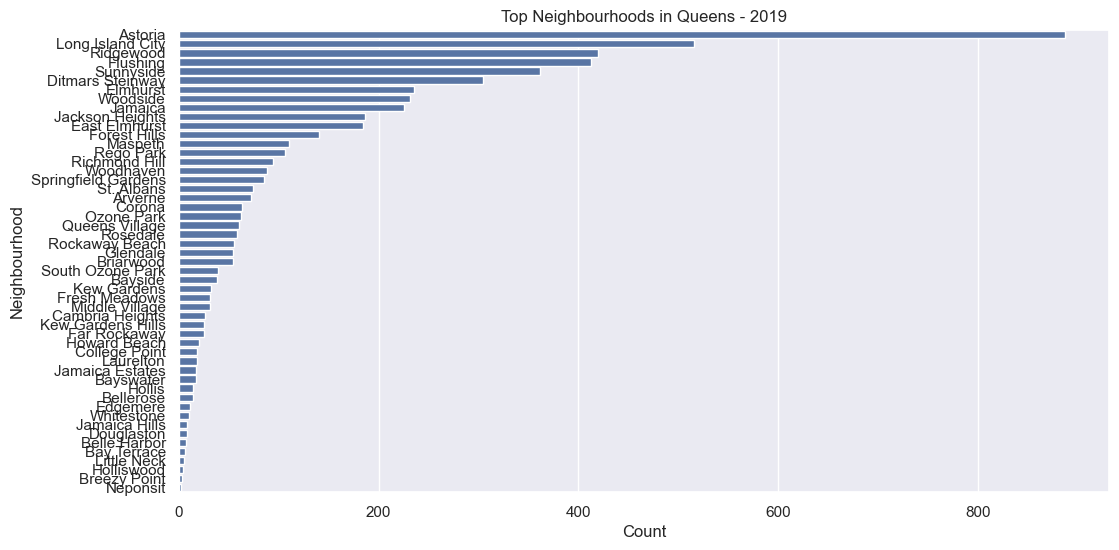

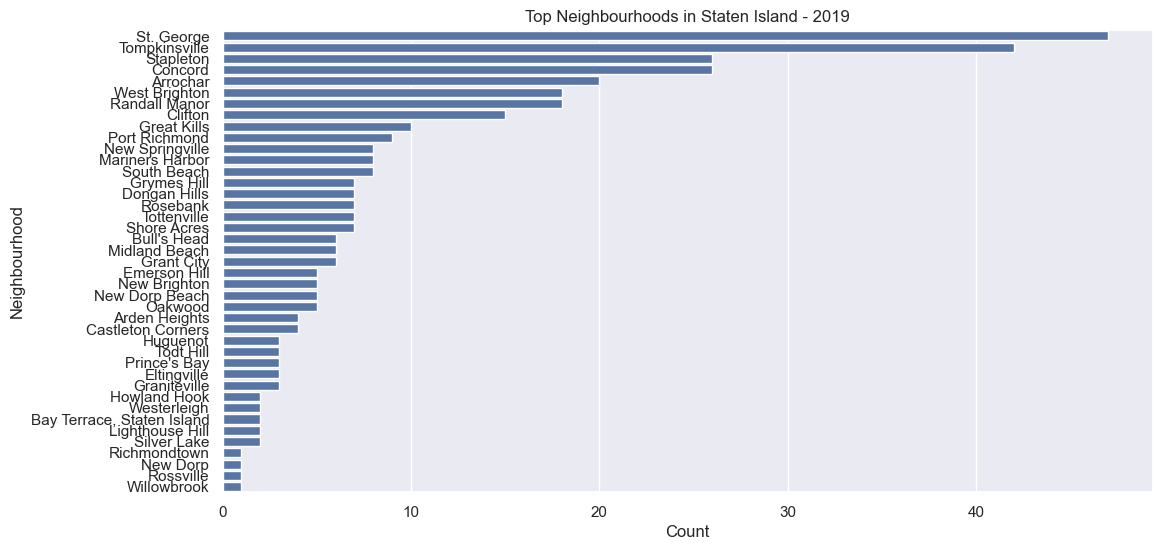

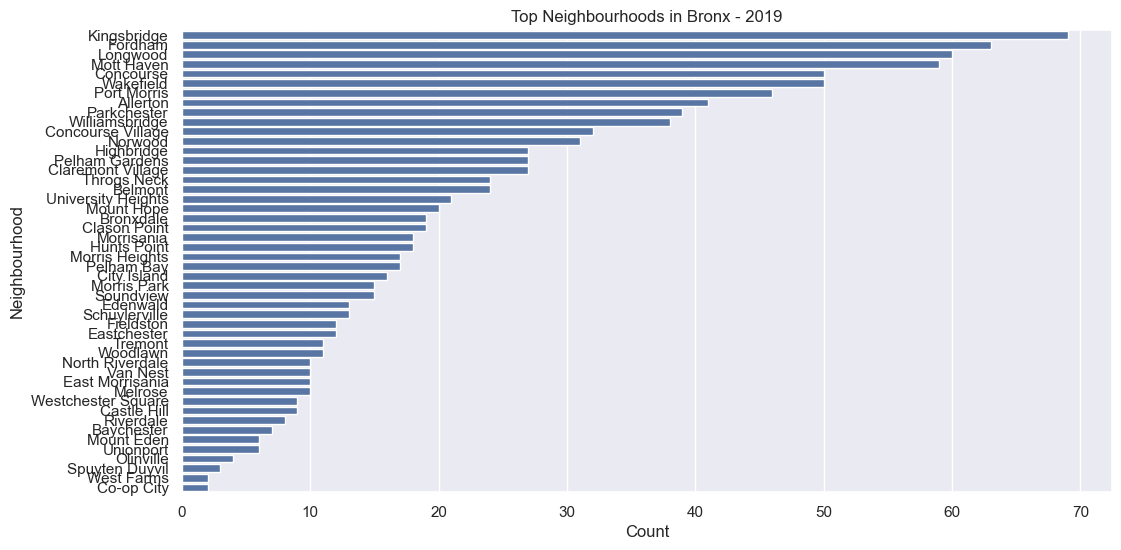

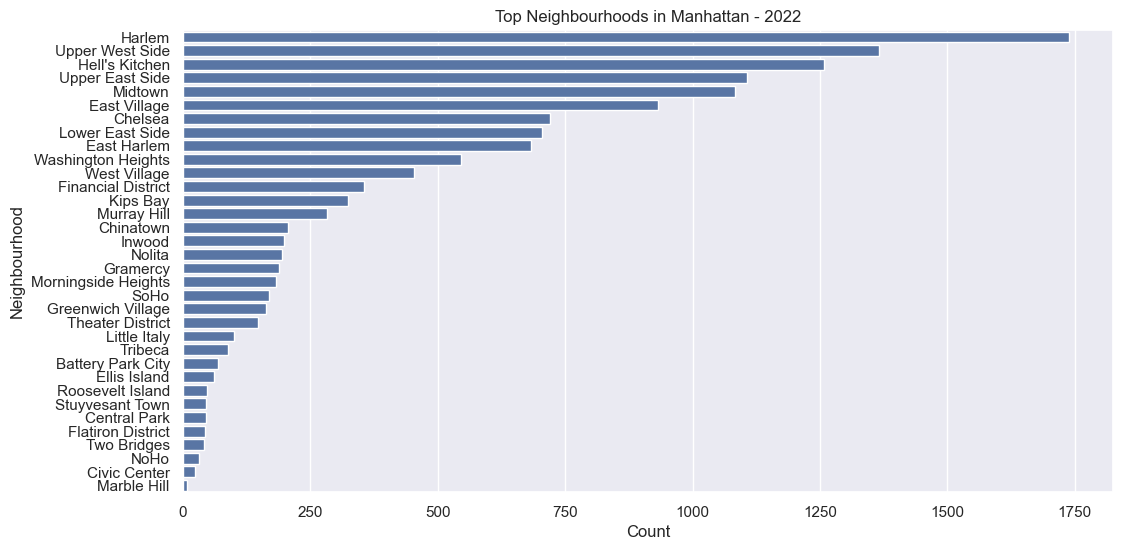

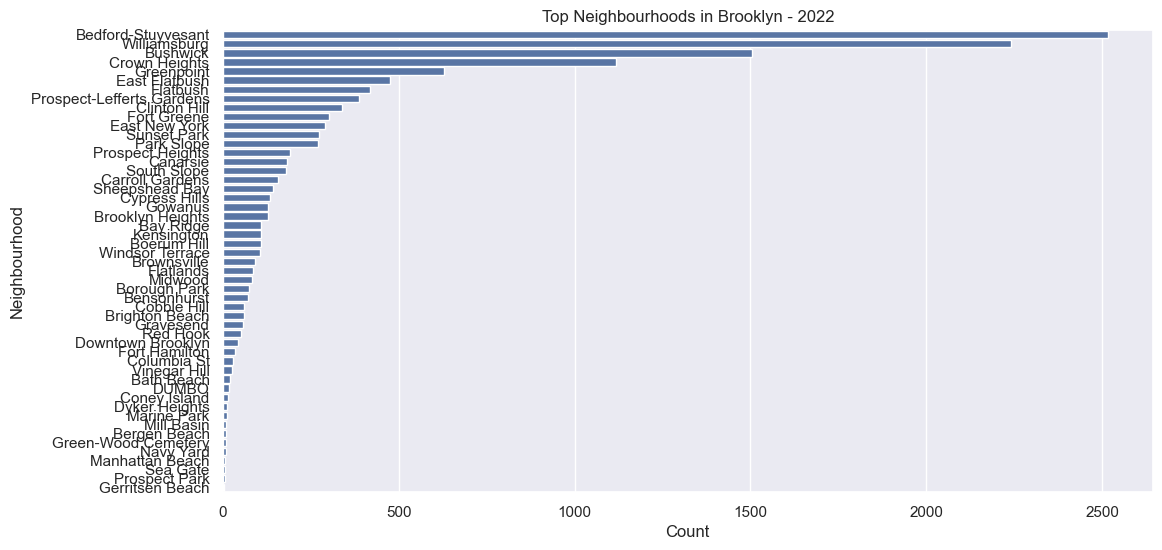

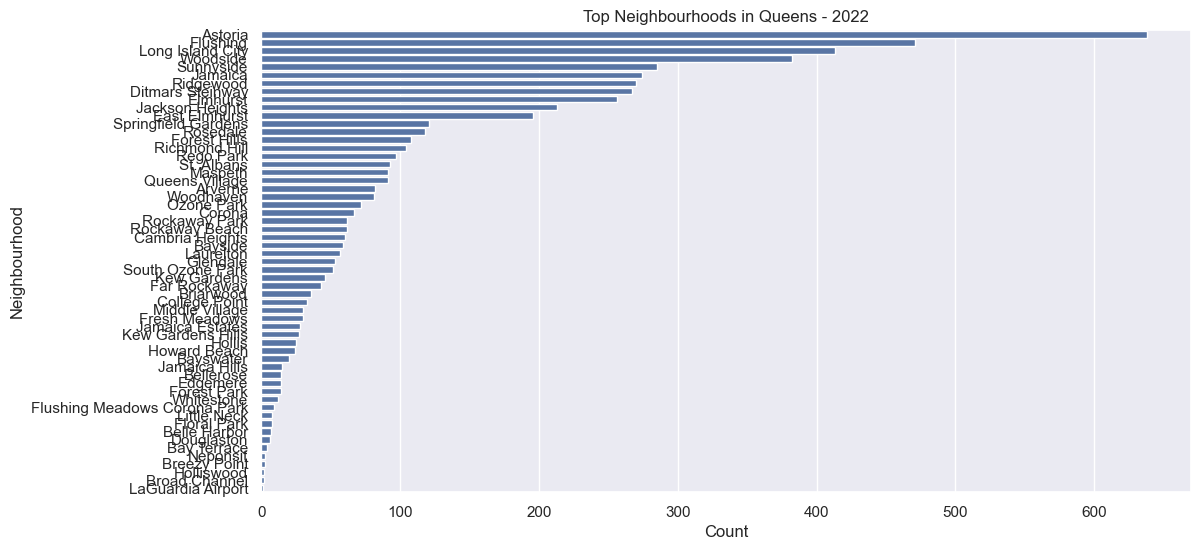

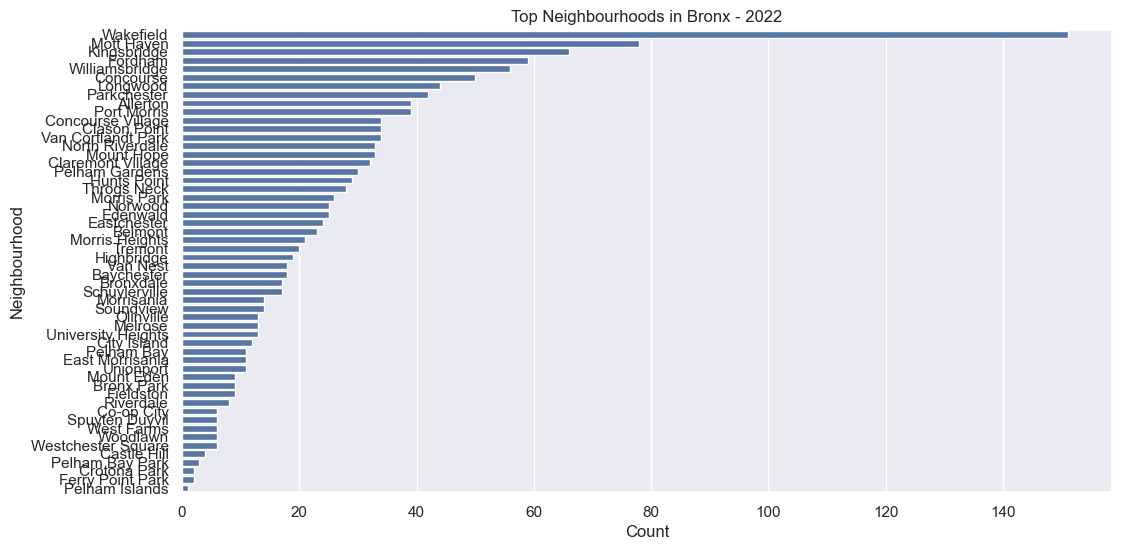

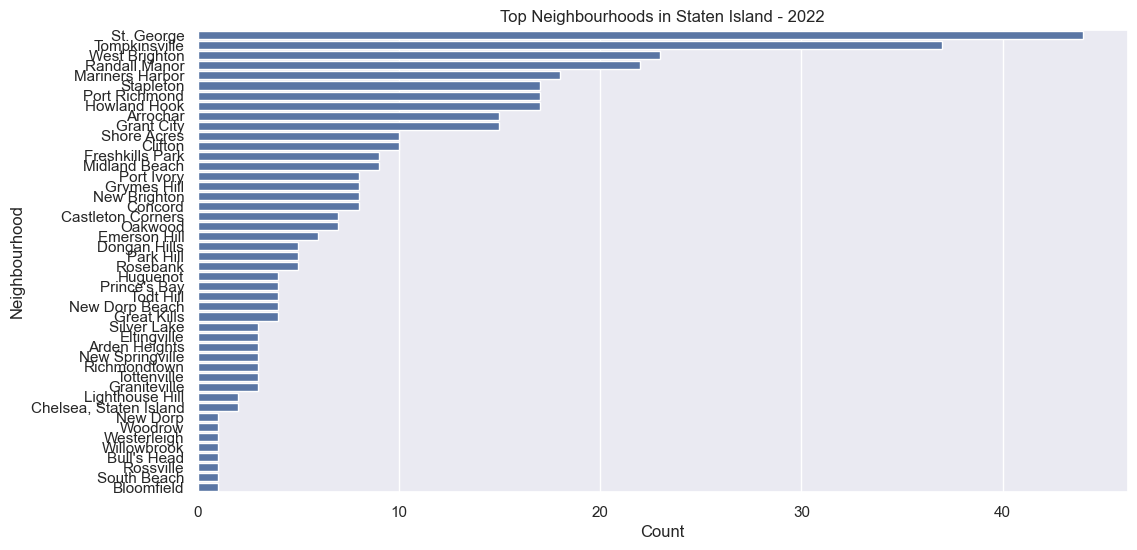

In [140]:
# Neighbourhood Analysis
# Neighbourhood Group Analysis for 2019
plt.figure(figsize=(12, 6))
sns.countplot(y='neighbourhood_group', data=df_airbnb_2019, order=df_airbnb_2019['neighbourhood_group'].value_counts().index)
plt.title('Neighbourhood Group Distribution in 2019')
plt.xlabel('Count')
plt.ylabel('Neighbourhood Group')
plt.show()

# Neighbourhood Group Analysis for 2022
plt.figure(figsize=(12, 6))
sns.countplot(y='neighbourhood_group', data=df_airbnb_2022, order=df_airbnb_2022['neighbourhood_group'].value_counts().index)
plt.title('Neighbourhood Group Distribution in 2022')
plt.xlabel('Count')
plt.ylabel('Neighbourhood Group')
plt.show()

# Top Neighbourhoods in each Neighbourhood Group for 2019
for group in df_airbnb_2019['neighbourhood_group'].unique():
    plt.figure(figsize=(12, 6))
    sns.countplot(y='neighbourhood', data=df_airbnb_2019[df_airbnb_2019['neighbourhood_group'] == group], order=df_airbnb_2019[df_airbnb_2019['neighbourhood_group'] == group]['neighbourhood'].value_counts().index)
    plt.title(f'Top Neighbourhoods in {group} - 2019')
    plt.xlabel('Count')
    plt.ylabel('Neighbourhood')
    plt.show()

# Top Neighbourhoods in each Neighbourhood Group for 2022
for group in df_airbnb_2022['neighbourhood_group'].unique():
    plt.figure(figsize=(12, 6))
    sns.countplot(y='neighbourhood', data=df_airbnb_2022[df_airbnb_2022['neighbourhood_group'] == group], order=df_airbnb_2022[df_airbnb_2022['neighbourhood_group'] == group]['neighbourhood'].value_counts().index)
    plt.title(f'Top Neighbourhoods in {group} - 2022')
    plt.xlabel('Count')
    plt.ylabel('Neighbourhood')
    plt.show()

## ENCODING

In [141]:
# Feature selection for each dataset
features_2019 = df_airbnb_2019[['neighbourhood_group', 'room_type', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'sentiment_score']]
target_2019 = df_airbnb_2019['price']

features_2022 = df_airbnb_2022[['neighbourhood_group', 'room_type', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'sentiment_score']]
target_2022 = df_airbnb_2022['price']

# Handling missing values
features_2019['reviews_per_month'] = features_2019['reviews_per_month'].fillna(0)
features_2022['reviews_per_month'] = features_2022['reviews_per_month'].fillna(0)

# Encoding categorical features
categorical_features = ['neighbourhood_group', 'room_type']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Scaling numerical features
numerical_features = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'sentiment_score']
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Column Transformer for applying transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Splitting the datasets into training and testing sets
X_train_2019, X_test_2019, y_train_2019, y_test_2019 = train_test_split(features_2019, target_2019, test_size=0.2, random_state=42)
X_train_2022, X_test_2022, y_train_2022, y_test_2022 = train_test_split(features_2022, target_2022, test_size=0.2, random_state=42)

# Applying transformations
X_train_2019 = preprocessor.fit_transform(X_train_2019)
X_test_2019 = preprocessor.transform(X_test_2019)

X_train_2022 = preprocessor.fit_transform(X_train_2022)
X_test_2022 = preprocessor.transform(X_test_2022)


/var/folders/8y/bb2m_8n915jb0h8mj_mz13080000gn/T/ipykernel_9471/3447984821.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_2019['reviews_per_month'] = features_2019['reviews_per_month'].fillna(0)
/var/folders/8y/bb2m_8n915jb0h8mj_mz13080000gn/T/ipykernel_9471/3447984821.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_2022['reviews_per_month'] = features_2022['reviews_per_month'].fillna(0)


## ML Algorithms Experimentation
In this section, we experiment with SVM, KNN, and Random Forests, and evaluate them using appropriate metrics.

## SVR

In [142]:
# Create the SVM model
svm_model_2019 = SVR(kernel='rbf', C=1.0, gamma='scale', epsilon=0.1)
svm_model_2022 = SVR(kernel='rbf', C=1.0, gamma='scale', epsilon=0.1)

# Train the model on the 2019 dataset
svm_model_2019.fit(X_train_2019, y_train_2019)

# Predict on the test set
y_pred_2019 = svm_model_2019.predict(X_test_2019)

# Evaluate the model
mse_2019 = mean_squared_error(y_test_2019, y_pred_2019)
r2_2019 = r2_score(y_test_2019, y_pred_2019)
print("2019 Model - MSE:", mse_2019, "R2:", r2_2019)

# Train the model on the 2022 dataset
svm_model_2022.fit(X_train_2022, y_train_2022)

# Predict on the test set
y_pred_2022 = svm_model_2022.predict(X_test_2022)

# Evaluate the model
mse_2022 = mean_squared_error(y_test_2022, y_pred_2022)
r2_2022 = r2_score(y_test_2022, y_pred_2022)
print("2022 Model - MSE:", mse_2022, "R2:", r2_2022)

2019 Model - MSE: 2332.932206246151 R2: 0.49918405022235324
2022 Model - MSE: 3811.1840075915384 R2: 0.41445339966058714


## KNN

In [143]:
# Create the KNN Regressor model
knn_model_2019 = KNeighborsRegressor()
knn_model_2022 = KNeighborsRegressor()

# Train the model on 2019 and 2022 data
knn_model_2019.fit(X_train_2019, y_train_2019)
knn_model_2022.fit(X_train_2022, y_train_2022)

# Predictions
y_pred_2019 = knn_model_2019.predict(X_test_2019)
y_pred_2022 = knn_model_2022.predict(X_test_2022)

# Evaluate the model
mse_2019 = mean_squared_error(y_test_2019, y_pred_2019)
r2_2019 = r2_score(y_test_2019, y_pred_2019)

mse_2022 = mean_squared_error(y_test_2022, y_pred_2022)
r2_2022 = r2_score(y_test_2022, y_pred_2022)

print("2019 MSE:", mse_2019, "R2:", r2_2019)
print("2022 MSE:", mse_2022, "R2:", r2_2022)

2019 MSE: 2345.58921720196 R2: 0.4964669404211305
2022 MSE: 3494.4627058481233 R2: 0.4631141520990735


## RANDOM FOREST

In [144]:
# Create the Random Forest model
random_forest_model_2019 = RandomForestRegressor(random_state=42)
random_forest_model_2022 = RandomForestRegressor(random_state=42)

# Train the model on the 2019 data
random_forest_model_2019.fit(X_train_2019, y_train_2019)

# Train the model on the 2022 data
random_forest_model_2022.fit(X_train_2022, y_train_2022)

# Predictions on the test set
y_pred_2019 = random_forest_model_2019.predict(X_test_2019)
y_pred_2022 = random_forest_model_2022.predict(X_test_2022)

# Evaluate the model
mse_2019 = mean_squared_error(y_test_2019, y_pred_2019)
mse_2022 = mean_squared_error(y_test_2022, y_pred_2022)
r2_2019 = r2_score(y_test_2019, y_pred_2019)
r2_2022 = r2_score(y_test_2022, y_pred_2022)

# Print the evaluation results
print("2019 Data - Mean Squared Error: ", mse_2019)
print("2019 Data - R-squared: ", r2_2019)
print("2022 Data - Mean Squared Error: ", mse_2022)
print("2022 Data - R-squared: ", r2_2022)

2019 Data - Mean Squared Error:  1994.1527116285608
2019 Data - R-squared:  0.5719106274918677
2022 Data - Mean Squared Error:  2916.014970561438
2022 Data - R-squared:  0.5519862989690423


## Hyper-parameter Tuning
This section focuses on tuning hyper-parameters for the chosen ML models.

## SVR 2019

In [145]:
# Define the parameter grid to search
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2, 0.5]
}

# Create a base model
svm = SVR()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train_2019, y_train_2019)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Use the best estimator for predictions
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test_2019)


Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END .....C=0.1, epsilon=0.1, gamma=scale, kernel=linear; total time=  54.8s
[CV] END .....C=0.1, epsilon=0.1, gamma=scale, kernel=linear; total time=  55.0s
[CV] END .....C=0.1, epsilon=0.1, gamma=scale, kernel=linear; total time=  55.1s
[CV] END .......C=0.1, epsilon=0.1, gamma=scale, kernel=poly; total time= 1.1min
[CV] END .......C=0.1, epsilon=0.1, gamma=scale, kernel=poly; total time= 1.1min
[CV] END ........C=0.1, epsilon=0.1, gamma=scale, kernel=rbf; total time= 1.7min
[CV] END ........C=0.1, epsilon=0.1, gamma=scale, kernel=rbf; total time= 1.7min
[CV] END ........C=0.1, epsilon=0.1, gamma=scale, kernel=rbf; total time= 1.7min
[CV] END ......C=0.1, epsilon=0.1, gamma=auto, kernel=linear; total time=  51.9s
[CV] END ......C=0.1, epsilon=0.1, gamma=auto, kernel=linear; total time=  52.4s
[CV] END ......C=0.1, epsilon=0.1, gamma=auto, kernel=linear; total time=  52.0s
[CV] END .......C=0.1, epsilon=0.1, gamma=scale

In [146]:
# Create the SVM model
svm_model_2019 = SVR(kernel='rbf', C=10, gamma='scale', epsilon=0.2)

# Train the model on the 2019 dataset
svm_model_2019.fit(X_train_2019, y_train_2019)

# Predict on the test set
y_pred_2019 = svm_model_2019.predict(X_test_2019)

# Evaluate the model
mse_2019 = mean_squared_error(y_test_2019, y_pred_2019)
r2_2019 = r2_score(y_test_2019, y_pred_2019)
print("2019 Model - MSE:", mse_2019, "R2:", r2_2019)

2019 Model - MSE: 2180.9588272748692 R2: 0.5318085268045032


## SVR 2022

In [147]:
# Define the parameter grid to search
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2, 0.5]
}

# Create a base model
svm = SVR()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train_2022, y_train_2022)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Use the best estimator for predictions
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test_2022)


Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END .....C=0.1, epsilon=0.1, gamma=scale, kernel=linear; total time=  31.2s
[CV] END .....C=0.1, epsilon=0.1, gamma=scale, kernel=linear; total time=  31.3s
[CV] END .....C=0.1, epsilon=0.1, gamma=scale, kernel=linear; total time=  31.7s
[CV] END .......C=0.1, epsilon=0.1, gamma=scale, kernel=poly; total time=  38.1s
[CV] END .......C=0.1, epsilon=0.1, gamma=scale, kernel=poly; total time=  38.4s
[CV] END ........C=0.1, epsilon=0.1, gamma=scale, kernel=rbf; total time=  59.6s
[CV] END ........C=0.1, epsilon=0.1, gamma=scale, kernel=rbf; total time=  59.6s
[CV] END ........C=0.1, epsilon=0.1, gamma=scale, kernel=rbf; total time=  60.0s
[CV] END ......C=0.1, epsilon=0.1, gamma=auto, kernel=linear; total time=  30.1s
[CV] END ......C=0.1, epsilon=0.1, gamma=auto, kernel=linear; total time=  29.8s
[CV] END .......C=0.1, epsilon=0.1, gamma=scale, kernel=poly; total time=  37.1s
[CV] END ......C=0.1, epsilon=0.1, gamma=auto, 

In [148]:
# Create the SVM model
svm_model_2022 = SVR(kernel='rbf', C=10, gamma='scale', epsilon=0.5)

# Train the model on the 2019 dataset
svm_model_2022.fit(X_train_2022, y_train_2022)

# Predict on the test set
y_pred_2022 = svm_model_2022.predict(X_test_2022)

# Evaluate the model
mse_2022 = mean_squared_error(y_test_2022, y_pred_2022)
r2_2022 = r2_score(y_test_2022, y_pred_2022)
print("2022 Model - MSE:", mse_2022, "R2:", r2_2022)

2022 Model - MSE: 3443.270484723929 R2: 0.47097927511160376


## KNN 2019


In [149]:
# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

# Create a KNN model
knn_model = KNeighborsRegressor()

# Grid Search with cross-validation
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model on data
grid_search.fit(X_train_2019, y_train_2019)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)


Best parameters: {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}


In [150]:
# Create the KNN model with the best parameters
knn = KNeighborsRegressor(algorithm='auto', n_neighbors=10, p=1, weights='distance')

# Fit the model to the training data
knn.fit(X_train_2019, y_train_2019)

# Make predictions on the test data
y_pred_2019 = knn.predict(X_test_2019)

# Evaluate the model
mse_2019 = mean_squared_error(y_test_2019, y_pred_2019)
r2_2019 = r2_score(y_test_2019, y_pred_2019)
print("2019 Model - MSE:", mse_2019, "R2:", r2_2019)

2019 Model - MSE: 2133.030144431249 R2: 0.54209748794776


## KNN 2022

In [151]:
# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

# Create a KNN model
knn_model = KNeighborsRegressor()

# Grid Search with cross-validation
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model on data
grid_search.fit(X_train_2022, y_train_2022)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

Best parameters: {'algorithm': 'kd_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}


In [152]:
# Create the KNN model with the best parameters
knn = KNeighborsRegressor(algorithm='kd_tree', n_neighbors=10, p=1, weights='distance')

# Fit the model to the training data
knn.fit(X_train_2022, y_train_2022)

# Make predictions on the test data
y_pred_2022 = knn.predict(X_test_2022)

# Evaluate the model
mse_2022 = mean_squared_error(y_test_2022, y_pred_2022)
r2_2022 = r2_score(y_test_2022, y_pred_2022)
print("2022 Model - MSE:", mse_2022, "R2:", r2_2022)

2022 Model - MSE: 3173.3225441892964 R2: 0.5124538138727406


## RANDOM FOREST 2019

In [153]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                           param_grid=param_grid, 
                           cv=5,
                           n_jobs=-1, 
                           verbose=2, 
                           scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_2019, y_train_2019)

# Find the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best parameters:", best_params)
print("Best score:", best_score)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   7.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   8.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  19.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  19.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   9.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   7.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   8.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   9.5s
[CV] END max_depth=None

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
215 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.

Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Best score: -1922.4547696781126


In [154]:
# Create the Random Forest model with the best parameters
rf_model = RandomForestRegressor(
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=500,
    random_state=42
)

# Fit the model on the training data
rf_model.fit(X_train_2019, y_train_2019)

# Make predictions on the test data
y_pred_2019 = rf_model.predict(X_test_2019)

# Evaluate the model
mse_2019 = mean_squared_error(y_test_2019, y_pred_2019)
r2_2019 = r2_score(y_test_2019, y_pred_2019)
print("2019 Model - MSE:", mse_2019, "R2:", r2_2019)

2022 Model - MSE: 1911.9472144583187 R2: 0.5895578716046761


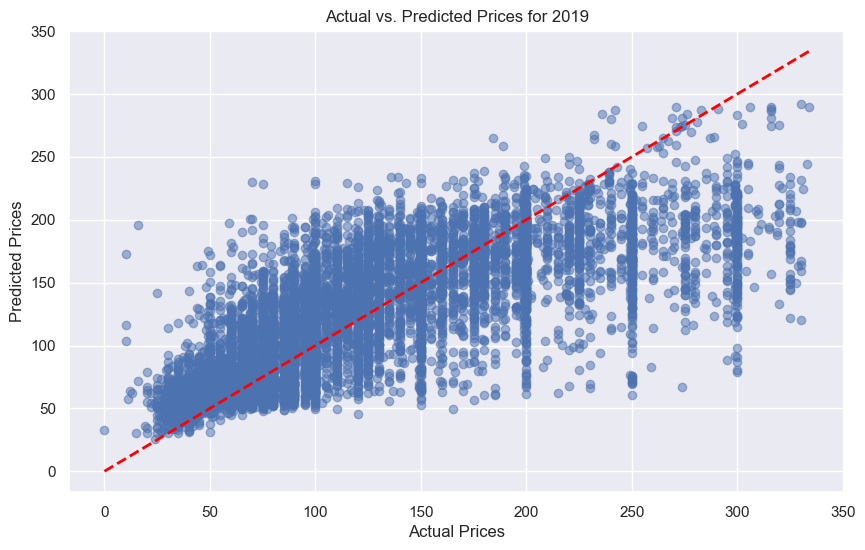

In [155]:
# Scatter plot of actual vs. predicted values for Random Forest 2019
plt.figure(figsize=(10, 6))
plt.scatter(y_test_2019, y_pred_2019, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Prices for 2019')

# Adding a reference line
max_value = max(max(y_test_2019), max(y_pred_2019))
min_value = min(min(y_test_2019), min(y_pred_2019))
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', lw=2)

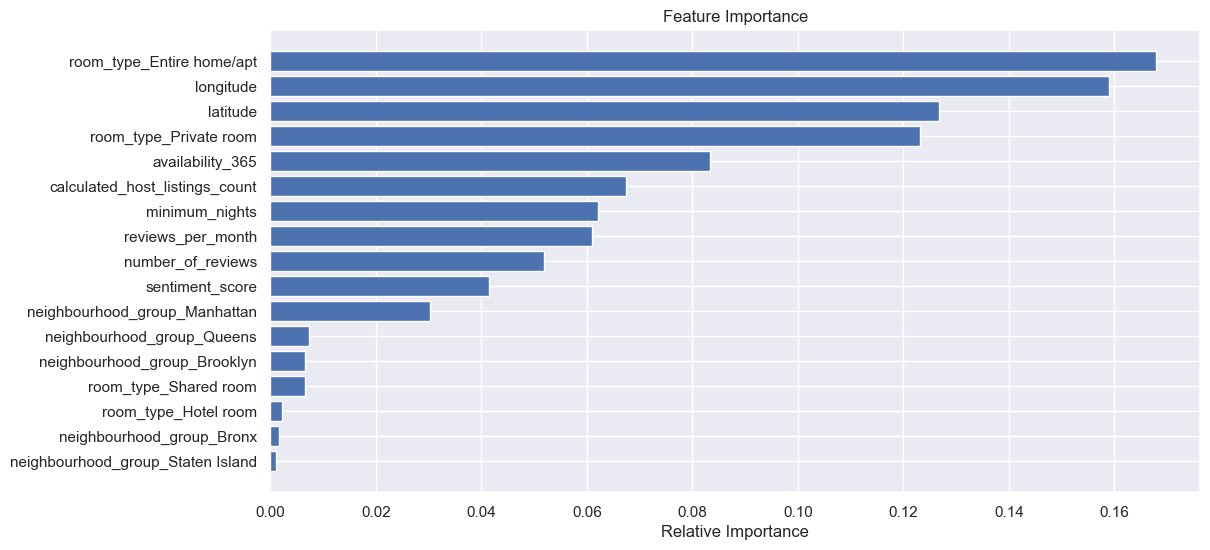

In [162]:
# DELETE THIS LINE BELOW ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
import numpy as np
# Getting feature importance
feature_importances_2019 = rf_model.feature_importances_

# Get feature names
feature_names = preprocessor.transformers_[0][1].get_feature_names_out(numerical_features)
feature_names = np.concatenate([feature_names, preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)])

# Sorting the feature importances
sorted_idx = np.argsort(feature_importances_2019)
pos = np.arange(sorted_idx.shape[0]) + .5

# Create plot
plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importances_2019[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

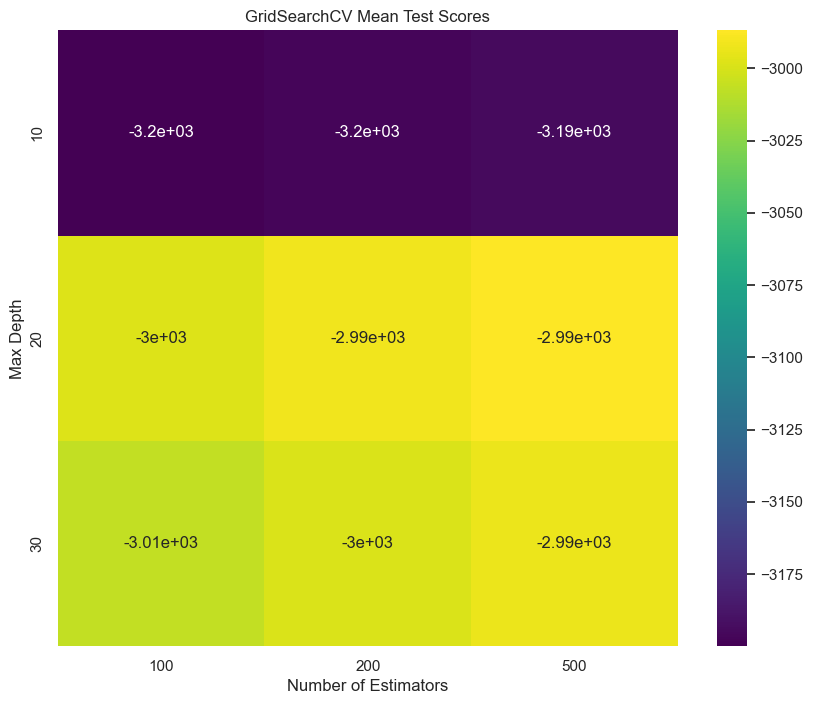

In [164]:
# Convert GridSearchCV results to a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Visualizing the effect of 'max_depth' and 'n_estimators'
pivot_table = results.pivot_table(values='mean_test_score', 
                                  index='param_max_depth', 
                                  columns='param_n_estimators')

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt='.3g', cmap='viridis')
plt.title('GridSearchCV Mean Test Scores')
plt.xlabel('Number of Estimators')
plt.ylabel('Max Depth')
plt.show()

## RANDOM FOREST 2022

In [156]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                           param_grid=param_grid, 
                           cv=5,
                           n_jobs=-1, 
                           verbose=2, 
                           scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_2022, y_train_2022)

# Find the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best parameters:", best_params)
print("Best score:", best_score)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   9.3s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  10.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.8s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  23.6s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   9.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.6s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  23.5s
[CV] END max_depth=None, max_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.

Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best score: -2957.5268217342464


In [159]:
# Create the Random Forest model with the best parameters
rf_model = RandomForestRegressor(
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=500,
    random_state=42
)

# Fit the model on the training data
rf_model.fit(X_train_2022, y_train_2022)

# Make predictions on the test data
y_pred_2022 = rf_model.predict(X_test_2022)

# Evaluate the model
mse_2022 = mean_squared_error(y_test_2022, y_pred_2022)
r2_2022 = r2_score(y_test_2022, y_pred_2022)
print("2022 Model - MSE:", mse_2022, "R2:", r2_2022)

2022 Model - MSE: 2827.666750145421 R2: 0.5655600335375097


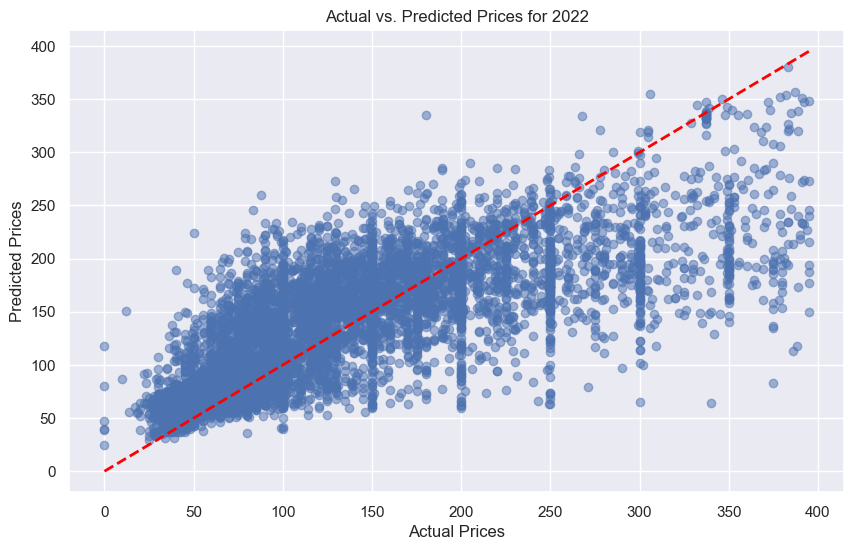

In [160]:
# Scatter plot of actual vs. predicted values for Random Forest 2022
plt.figure(figsize=(10, 6))
plt.scatter(y_test_2022, y_pred_2022, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Prices for 2022')

# Adding a reference line
max_value = max(max(y_test_2022), max(y_pred_2022))
min_value = min(min(y_test_2022), min(y_pred_2022))
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', lw=2)

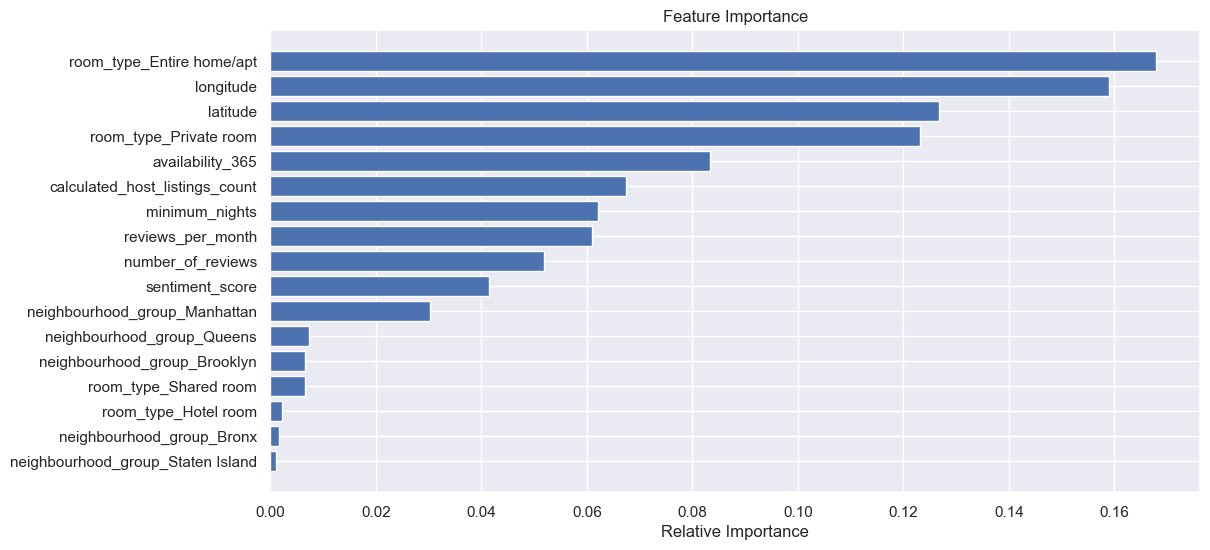

In [163]:
# Getting feature importance
feature_importances_2022 = rf_model.feature_importances_

# Get feature names
feature_names = preprocessor.transformers_[0][1].get_feature_names_out(numerical_features)
feature_names = np.concatenate([feature_names, preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)])

# Sorting the feature importances
sorted_idx = np.argsort(feature_importances_2022)
pos = np.arange(sorted_idx.shape[0]) + .5

# Create plot
plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importances_2022[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

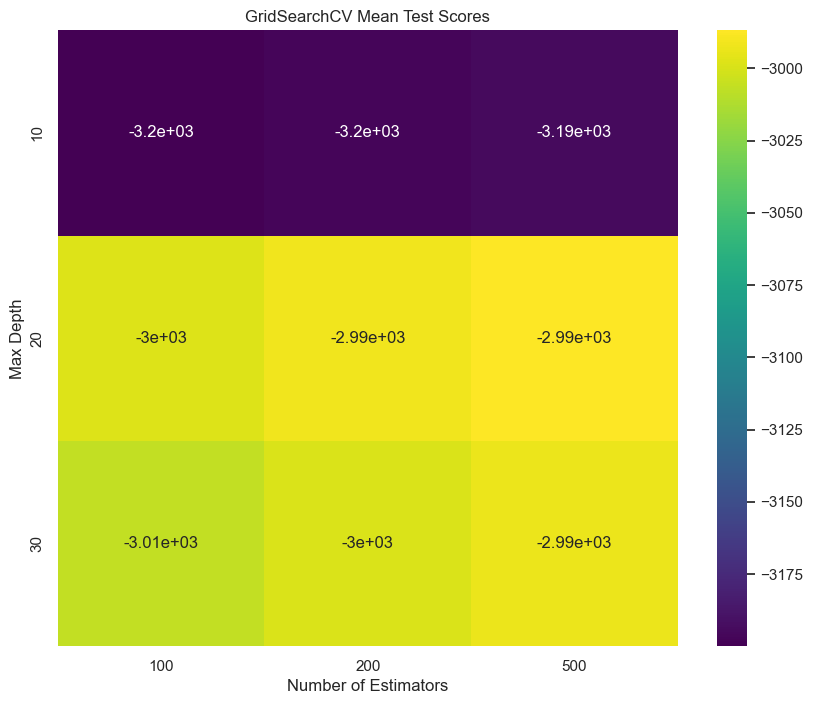

In [165]:
# Convert GridSearchCV results to a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Visualizing the effect of 'max_depth' and 'n_estimators'
pivot_table = results.pivot_table(values='mean_test_score', 
                                  index='param_max_depth', 
                                  columns='param_n_estimators')

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt='.3g', cmap='viridis')
plt.title('GridSearchCV Mean Test Scores')
plt.xlabel('Number of Estimators')
plt.ylabel('Max Depth')
plt.show()